In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

In [3]:
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pip install --upgrade --force-reinstall pandas

In [6]:
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [8]:
import json
kaggle_username = "chrystianlima"
kaggle_key = "9b76f7fd0f1015aa0673760929e2f423"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

#### Download the Bike Sharing Demand data from Kaggle.

In [9]:
!kaggle competitions download -c bike-sharing-demand
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 5.79MB/s]
/bin/sh: 1: unzip: not found


In [10]:
import zipfile
with zipfile.ZipFile('bike-sharing-demand.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

#### Load all datasets from the Bike Sharing Demand competition into Pandas.

In [11]:
df_train = pd.read_csv('train.csv',parse_dates=['datetime'])
df_test = pd.read_csv('test.csv',parse_dates=['datetime'])
submission = pd.read_csv('sampleSubmission.csv')

In [6]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [9]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [10]:
df_train = df_train.drop(columns=['registered','casual'])

#### Create a histogram of all features in the train dataset.

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>, <AxesSubplot:>]],
      dtype=object)

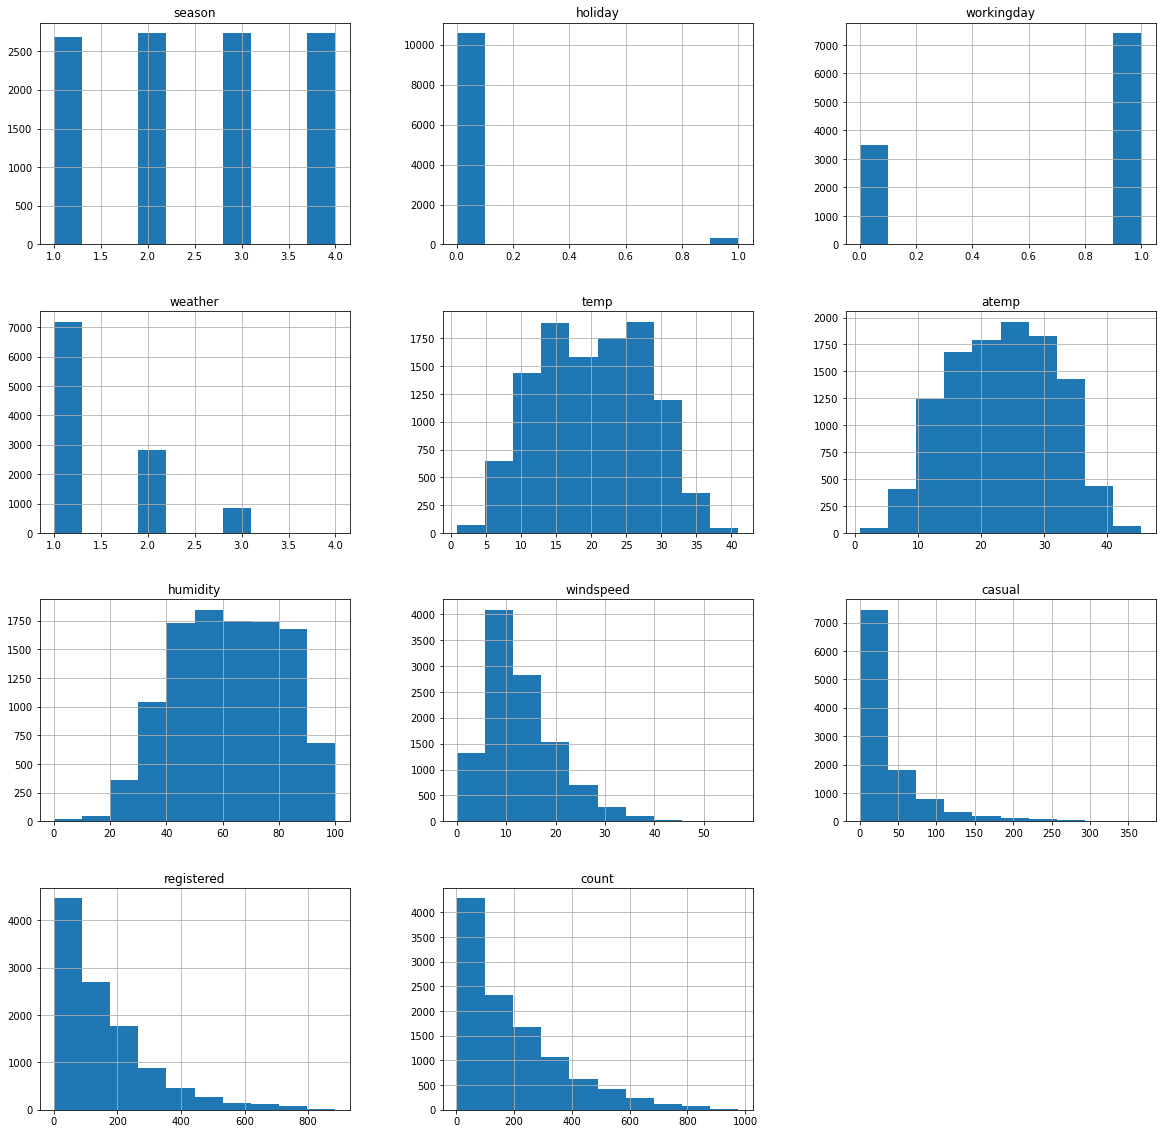

In [14]:
df_train.hist(figsize=(20,20))

### First Round: No feature engineering and no hyper parameter
#### Train a Tabular Prediction model on the training set. (1/3)

In [12]:
predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(train_data=df_train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20220128_204407/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220128_204407/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2923.66 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column va

[1000]	train_set's rmse: 123.806	valid_set's rmse: 134.369
[2000]	train_set's rmse: 117.412	valid_set's rmse: 133.705


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 123.42	valid_set's rmse: 141.5


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 125.097	valid_set's rmse: 128.797
[2000]	train_set's rmse: 119.003	valid_set's rmse: 127.909
[3000]	train_set's rmse: 114.63	valid_set's rmse: 127.431
[4000]	train_set's rmse: 111.295	valid_set's rmse: 126.943
[5000]	train_set's rmse: 108.576	valid_set's rmse: 126.844
[6000]	train_set's rmse: 106.085	valid_set's rmse: 126.71


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.131	valid_set's rmse: 138.303
[2000]	train_set's rmse: 117.833	valid_set's rmse: 137.535


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.871	valid_set's rmse: 128.052
[2000]	train_set's rmse: 118.547	valid_set's rmse: 127.003
[3000]	train_set's rmse: 114.124	valid_set's rmse: 126.834
[4000]	train_set's rmse: 110.645	valid_set's rmse: 126.694


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.654	valid_set's rmse: 135.095
[2000]	train_set's rmse: 118.764	valid_set's rmse: 133.849
[3000]	train_set's rmse: 114.615	valid_set's rmse: 133.509
[4000]	train_set's rmse: 111.249	valid_set's rmse: 133.472
[5000]	train_set's rmse: 108.455	valid_set's rmse: 133.281


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.01	valid_set's rmse: 139.355
[2000]	train_set's rmse: 117.819	valid_set's rmse: 138.312
[3000]	train_set's rmse: 113.4	valid_set's rmse: 137.886
[4000]	train_set's rmse: 110.032	valid_set's rmse: 137.758


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.47	valid_set's rmse: 135.412


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.18	valid_set's rmse: 137.579
[2000]	train_set's rmse: 117.782	valid_set's rmse: 136.664
[3000]	train_set's rmse: 113.447	valid_set's rmse: 136.246
[4000]	train_set's rmse: 109.982	valid_set's rmse: 136.227


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 124.641	valid_set's rmse: 132.484


	-134.0883	 = Validation score   (root_mean_squared_error)
	43.03s	 = Training   runtime
	2.31s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 347.89s of the 547.9s of remaining time.
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argu

[1000]	train_set's rmse: 96.0217	valid_set's rmse: 123.249


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 94.7479	valid_set's rmse: 135.635


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.3055	valid_set's rmse: 132.087


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 95.1635	valid_set's rmse: 131.521


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	-132.2864	 = Validation score   (root_mean_squared_error)
	13.46s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 331.98s of the 531.98s of remaining time.
	-118.4567	 = Validation score   (root_mean_squared_error)
	7.08s	 = Training   runtime


#### Model Evaluation

In [13]:
summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -114.951355       7.277437  501.515864                0.000954           0.497918            3       True         19
1   NeuralNetFastAI_BAG_L2 -115.588275       6.493976  476.114881                0.420649         104.636437            2       True         17
2        LightGBMXT_BAG_L2 -116.335539       6.273750  381.991861                0.200423          10.513417            2       True         12
3          CatBoost_BAG_L2 -116.558994       6.109352  396.650823                0.036025          25.172379            2       True         15
4          LightGBM_BAG_L2 -116.899022       6.162126  379.082967                0.088799           7.604524            2       True         13
5     ExtraTreesMSE_BAG_L2 -117.447003       6.566612  378.263567         

<AxesSubplot:xlabel='model'>

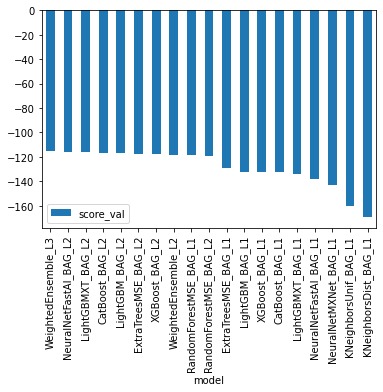

In [14]:
predictor.leaderboard(silent=True).plot(kind='bar', x='model',y='score_val')

In [40]:
predictions = predictor.predict(df_test)
predictions[predictions < 0] = 0

In [48]:
submission['count'] = predictions

In [49]:
submission.to_csv("submission.csv", index=False)

In [51]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "First submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 373kB/s]
Successfully submitted to Bike Sharing Demand

In [52]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                      date                 description                              status    publicScore  privateScore  
----------------------------  -------------------  ---------------------------------------  --------  -----------  ------------  
submission.csv                2022-01-28 21:04:40  First submission                         complete  1.39795      1.39795       
submission.csv                2022-01-28 21:01:58  First submission                         error     None         None          
submission.csv                2022-01-28 20:59:16  First submission                         error     None         None          
submission.csv                2022-01-28 20:55:47  First submission                         error     None         None          


### Second Round:  Feature engineering and no hyper parameter
#### Create a feature and add it to the train and test dataset.

In [16]:
df_train['day'] = df_train.datetime.dt.day
df_train['month'] = df_train.datetime.dt.month
df_train['hour'] = df_train.datetime.dt.hour

df_test['day'] = df_test.datetime.dt.day
df_test['month'] = df_test.datetime.dt.month
df_test['hour'] = df_test.datetime.dt.hour

In [17]:
bins_rush_hour = pd.IntervalIndex.from_tuples([(7, 9), (11, 13), (17, 18)])
bins_temp = pd.IntervalIndex.from_tuples([(32, 50), (0, 15), (16, 31)])

a = ['morning','lunch','evening']
b = ['hot','cold','mild']

df_train['rush_hour'] = np.array(a)[pd.cut(df_train["hour"], bins = bins_rush_hour).cat.codes]
df_train['temp_feels'] = np.array(b)[pd.cut(df_train["temp"], bins = bins_temp).cat.codes]

df_test['rush_hour'] = np.array(a)[pd.cut(df_test["hour"], bins = bins_rush_hour).cat.codes]
df_test['temp_feels'] = np.array(b)[pd.cut(df_test["temp"], bins = bins_temp).cat.codes]

#### Change the datatype of features in the train and test dataset.

In [18]:
df_train["season"] = df_train["season"].astype('category')
df_train["weather"] = df_train["weather"].astype('category')
df_train["rush_hour"] = df_train["season"].astype('category')
df_train["temp_feels"] = df_train["weather"].astype('category')

df_test["season"] = df_test["season"].astype('category')
df_test["weather"] = df_test["weather"].astype('category')
df_test["rush_hour"] = df_test["season"].astype('category')
df_test["temp_feels"] = df_test["weather"].astype('category')

array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'hour'}>]], dtype=object)

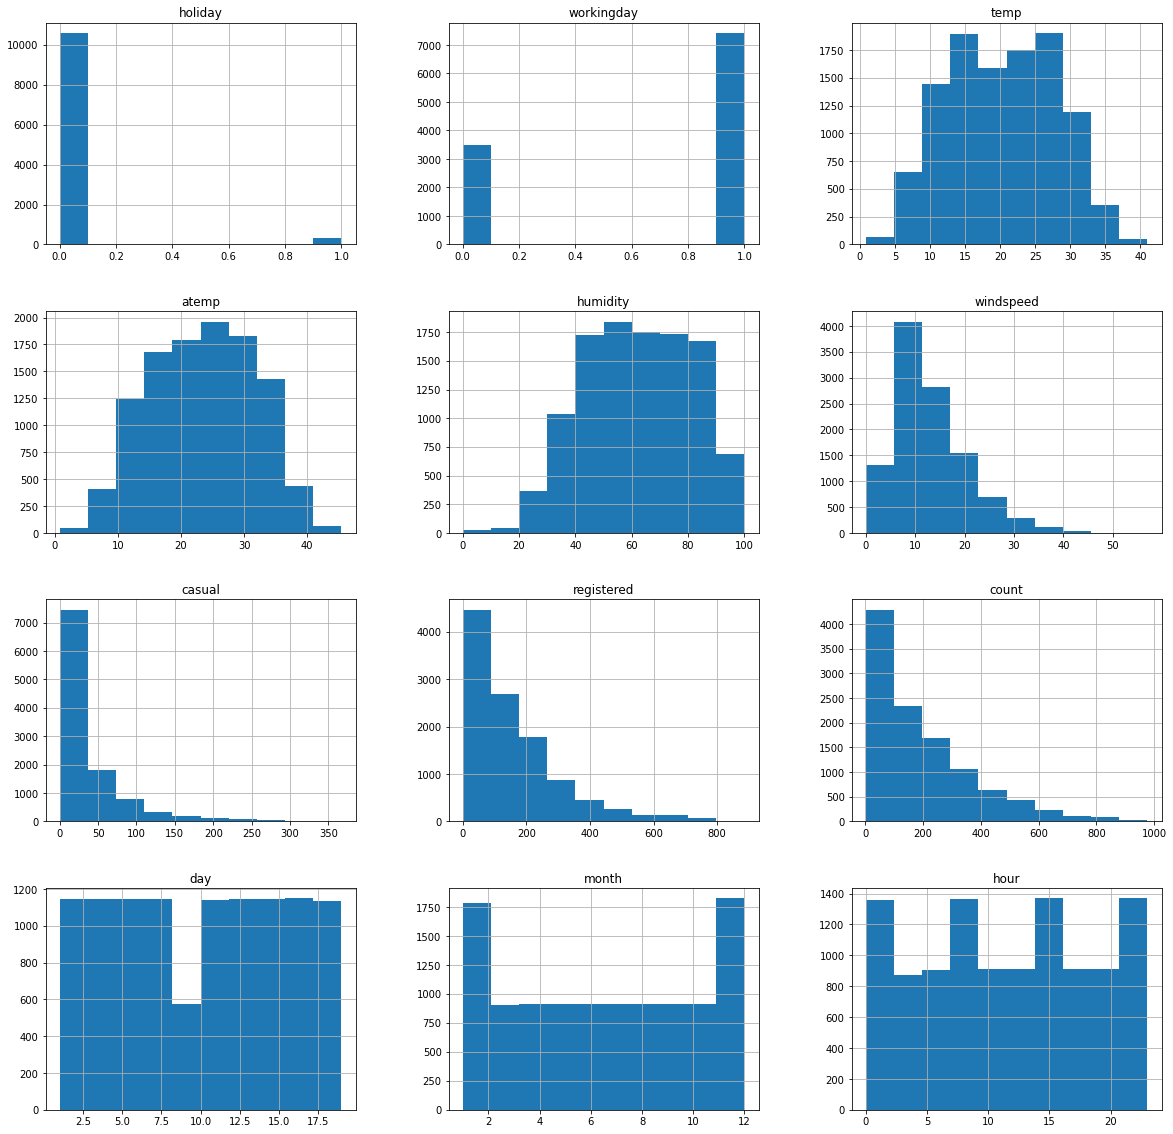

In [19]:
df_train.hist(figsize=(20,20))

#### Train a Tabular Prediction model on the training set. (2/3)

In [59]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(train_data=df_train, presets='best_quality', time_limit=600)

No path specified. Models will be saved in: "AutogluonModels/ag-20220128_211022/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220128_211022/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2371.88 MB
	Train Data (Original)  Memory Usage: 0.91 MB (0.0% of available memory)
	Inferring data type of each feature based on column v

[1000]	train_set's rmse: 30.5763	valid_set's rmse: 37.8628
[2000]	train_set's rmse: 25.7134	valid_set's rmse: 36.3395
[3000]	train_set's rmse: 22.9495	valid_set's rmse: 36.0013
[4000]	train_set's rmse: 20.997	valid_set's rmse: 35.9575
[5000]	train_set's rmse: 19.4652	valid_set's rmse: 35.9188


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.6958	valid_set's rmse: 41.1434
[2000]	train_set's rmse: 25.7603	valid_set's rmse: 38.8057
[3000]	train_set's rmse: 23.0839	valid_set's rmse: 38.0752
[4000]	train_set's rmse: 21.1595	valid_set's rmse: 37.8037
[5000]	train_set's rmse: 19.6799	valid_set's rmse: 37.6065
[6000]	train_set's rmse: 18.4326	valid_set's rmse: 37.5343
[7000]	train_set's rmse: 17.3663	valid_set's rmse: 37.5123
[8000]	train_set's rmse: 16.4115	valid_set's rmse: 37.4443
[9000]	train_set's rmse: 15.6075	valid_set's rmse: 37.445
[10000]	train_set's rmse: 14.8746	valid_set's rmse: 37.4621


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 31.1245	valid_set's rmse: 35.453
[2000]	train_set's rmse: 25.9671	valid_set's rmse: 34.3683


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.3186	valid_set's rmse: 41.3087
[2000]	train_set's rmse: 25.4542	valid_set's rmse: 39.7257
[3000]	train_set's rmse: 22.8134	valid_set's rmse: 39.1902
[4000]	train_set's rmse: 20.933	valid_set's rmse: 38.784
[5000]	train_set's rmse: 19.5162	valid_set's rmse: 38.5515
[6000]	train_set's rmse: 18.3397	valid_set's rmse: 38.3221
[7000]	train_set's rmse: 17.3437	valid_set's rmse: 38.1892
[8000]	train_set's rmse: 16.4264	valid_set's rmse: 38.0065
[9000]	train_set's rmse: 15.6455	valid_set's rmse: 37.9394
[10000]	train_set's rmse: 14.9384	valid_set's rmse: 37.891


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.6853	valid_set's rmse: 38.1507
[2000]	train_set's rmse: 25.6324	valid_set's rmse: 37.0208
[3000]	train_set's rmse: 22.9351	valid_set's rmse: 36.7783


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.297	valid_set's rmse: 40.928
[2000]	train_set's rmse: 25.4619	valid_set's rmse: 39.9752
[3000]	train_set's rmse: 22.8106	valid_set's rmse: 39.9249


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.7977	valid_set's rmse: 38.847
[2000]	train_set's rmse: 25.9845	valid_set's rmse: 36.0828
[3000]	train_set's rmse: 23.2472	valid_set's rmse: 35.2282
[4000]	train_set's rmse: 21.3142	valid_set's rmse: 34.8165
[5000]	train_set's rmse: 19.7962	valid_set's rmse: 34.7483
[6000]	train_set's rmse: 18.4917	valid_set's rmse: 34.6288
[7000]	train_set's rmse: 17.3981	valid_set's rmse: 34.6289


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.641	valid_set's rmse: 39.7027
[2000]	train_set's rmse: 25.5857	valid_set's rmse: 37.9547
[3000]	train_set's rmse: 22.8704	valid_set's rmse: 37.5504
[4000]	train_set's rmse: 20.9846	valid_set's rmse: 37.4091
[5000]	train_set's rmse: 19.4646	valid_set's rmse: 37.2817
[6000]	train_set's rmse: 18.2018	valid_set's rmse: 37.2605
[7000]	train_set's rmse: 17.1758	valid_set's rmse: 37.2012
[8000]	train_set's rmse: 16.2734	valid_set's rmse: 37.1987
[9000]	train_set's rmse: 15.4425	valid_set's rmse: 37.255


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 30.5405	valid_set's rmse: 41.07
[2000]	train_set's rmse: 25.5035	valid_set's rmse: 39.9622


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 31.1358	valid_set's rmse: 37.9854
[2000]	train_set's rmse: 26.1185	valid_set's rmse: 35.8714
[3000]	train_set's rmse: 23.3642	valid_set's rmse: 35.3426
[4000]	train_set's rmse: 21.4707	valid_set's rmse: 35.1005
[5000]	train_set's rmse: 19.9541	valid_set's rmse: 34.894
[6000]	train_set's rmse: 18.6793	valid_set's rmse: 34.8081
[7000]	train_set's rmse: 17.5844	valid_set's rmse: 34.8366


	-36.9101	 = Validation score   (root_mean_squared_error)
	90.81s	 = Training   runtime
	4.96s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 292.32s of the 492.3s of remaining time.
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.1363	valid_set's rmse: 35.5572
[2000]	train_set's rmse: 15.5114	valid_set's rmse: 35.4473


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.0431	valid_set's rmse: 36.9373
[2000]	train_set's rmse: 15.5393	valid_set's rmse: 36.1172
[3000]	train_set's rmse: 12.204	valid_set's rmse: 35.9179
[4000]	train_set's rmse: 9.99922	valid_set's rmse: 35.8485


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.4766	valid_set's rmse: 32.789


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.4591	valid_set's rmse: 38.1004
[2000]	train_set's rmse: 15.6967	valid_set's rmse: 37.1149
[3000]	train_set's rmse: 12.2044	valid_set's rmse: 36.7233
[4000]	train_set's rmse: 9.95476	valid_set's rmse: 36.6799


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.3995	valid_set's rmse: 37.384


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.6619	valid_set's rmse: 35.9544


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 20.9449	valid_set's rmse: 35.7483
[2000]	train_set's rmse: 15.4023	valid_set's rmse: 35.1407


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 21.3287	valid_set's rmse: 36.3231
[2000]	train_set's rmse: 15.6319	valid_set's rmse: 35.6071


	-36.5791	 = Validation score   (root_mean_squared_error)
	31.51s	 = Training   runtime
	1.29s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 255.68s of the 455.66s of remaining time.
	-41.3337	 = Validation score   (root_mean_squared_error)
	11.0s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 241.55s of the 441.53s of remaining time.
	Time limit exceeded... Skipping CatBoost_BAG_L1.
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 209.31s of the 409.29s of remaining time.
	-41.0043	 = Validation score   (root_mean_squared_error)
	4.59s	 = Training   runtime
	0.46s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 201.56s of the 401.54s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 29)
	Ran out of time, stopping training early. (Stopping on epoch 28)
	-46.1972	 = Validation score   (root_mean

#### Model Evaluation

In [60]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -35.202436       7.503991  324.604007                0.000979           0.561263            2       True          9
1      WeightedEnsemble_L3  -35.299344       9.526776  475.874199                0.000974           0.430480            3       True         16
2          CatBoost_BAG_L2  -35.624923       8.462499  386.490175                0.096155          57.797998            2       True         13
3     ExtraTreesMSE_BAG_L2  -35.721597       8.881383  336.193452                0.515039           7.501275            2       True         14
4          LightGBM_BAG_L2  -35.984219       8.507981  335.823179                0.141636           7.131002            2       True         11
5        LightGBMXT_BAG_L2  -36.238096       8.599268  337.876959         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.92163053871576,
  'KNeighborsDist_BAG_L1': -119.37260178212149,

<AxesSubplot:xlabel='model'>

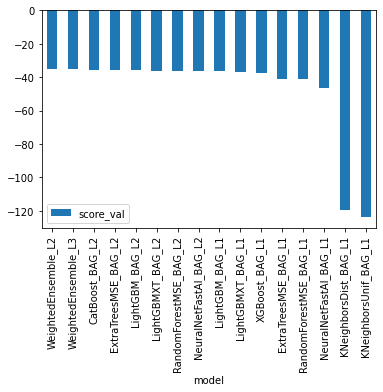

In [61]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar', x='model',y='score_val')

In [62]:
predictions = predictor_new_features.predict(df_test)

In [63]:
submissions_new_hpo = submission
submissions_new_hpo["count"] = predictions
submissions_new_hpo.loc[predictions < 0,"count"] = 0 

In [65]:
submissions_new_hpo.to_csv("submission_no_hpo.csv", index=False)

In [66]:
!kaggle competitions submit -c bike-sharing-demand -f submission_no_hpo.csv -m "Second Submission with New Features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 521kB/s]
Successfully submitted to Bike Sharing Demand

In [67]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                      date                 description                              status    publicScore  privateScore  
----------------------------  -------------------  ---------------------------------------  --------  -----------  ------------  
submission_no_hpo.csv         2022-01-28 21:21:23  Second Submission with New Features      complete  0.54732      0.54732       
submission.csv                2022-01-28 21:04:40  First submission                         complete  1.39795      1.39795       
submission.csv                2022-01-28 21:01:58  First submission                         error     None         None          
submission.csv                2022-01-28 20:59:16  First submission                         error     None         None          


### Third Round: Feature engineering and hyper parameter selection
#### Change the hyperparameters when training a Tabular Prediction model.

In [68]:
params={
    'searcher':'rl',
    'scheduler':'rl',
    'use_orig_features': False,
    'max_base_models': 50,
    'max_base_models_per_type': 10,
    'save_bag_folds': True
}

#### Train a Tabular Prediction model on the training set. (3/3)

In [69]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error').fit(train_data=df_train, presets='best_quality', time_limit=600,hyperparameter_tune_kwargs=params)
predictions = predictor_new_features.predict(df_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20220128_212143/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220128_212143/"
AutoGluon Version:  0.3.1
Train Data Rows:    10886
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1776.64 MB
	Train Data (Original)  Memory Usage: 0.91 MB (0.1% of available memory)
	Inferring data type of each feature based on column v

[1000]	train_set's rmse: 8.79021	valid_set's rmse: 36.3177
[2000]	train_set's rmse: 4.31516	valid_set's rmse: 36.127


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 9.16169	valid_set's rmse: 33.2606
[2000]	train_set's rmse: 4.30435	valid_set's rmse: 33.0592


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 8.88163	valid_set's rmse: 36.6216
[2000]	train_set's rmse: 4.26966	valid_set's rmse: 36.4199


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 8.87151	valid_set's rmse: 36.878
[2000]	train_set's rmse: 4.29378	valid_set's rmse: 36.7111
[3000]	train_set's rmse: 2.29818	valid_set's rmse: 36.6449


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 8.90966	valid_set's rmse: 34.3868


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 9.03523	valid_set's rmse: 35.1981
[2000]	train_set's rmse: 4.28481	valid_set's rmse: 34.9359


/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's rmse: 8.85414	valid_set's rmse: 36.3774
[2000]	train_set's rmse: 4.28709	valid_set's rmse: 36.0934


	-36.4746	 = Validation score   (root_mean_squared_error)
	69.17s	 = Training   runtime
	1.5s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 336.96s of remaining time.
	-36.3211	 = Validation score   (root_mean_squared_error)
	0.45s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Hyperparameter tuning model: LightGBMXT_BAG_L2 ...
Argument 'searcher' must be of type RLSearcher. Ignoring 'searcher' and creating searcher here.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/autogluon/tabular/trainer/abstract_trainer.py", line 1153, in _train_single_full
    hpo_models, hpo_model_performances, hpo_results = model.hyperparameter_tune(X=X, y=y, k_fold=k_fold, scheduler_options=hyperparameter_tune_kwargs, **model_fit_kwargs)
  File "/usr/local/lib/python3.6/site-packages/autogluon/core/models/abstract/abstract_model.py", line 830, in hyperp

#### Model Evaluation

*** Summary of fit() ***
Estimated performance of each model:
                        model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         WeightedEnsemble_L2  -36.321060       1.962111   74.238020                0.000963           0.451058            2       True          7
1        LightGBMLarge_BAG_L1  -36.474619       1.498421   69.172669                1.498421          69.172669            1       True          6
2         WeightedEnsemble_L3  -36.544355       4.515099  408.526644                0.001060           0.321104            3       True         12
3     ExtraTreesMSE_BAG_L2/T0  -36.868650       3.821085  238.344795                0.517280           7.095317            2       True          9
4   NeuralNetFastAI_BAG_L2/T0  -37.274386       3.804521  382.233724                0.500716         150.984246            2       True         10
5        LightGBMLarge_BAG_L2  -37.604643       3.496043

{'model_types': {'KNeighborsUnif_BAG_L1/T0': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1/T0': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1/T0': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2/T0': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2/T0': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2/T0': 'StackerEnsembleModel_NNFastAiTabular',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1/T0': -123.92163053871576,
  'KNeighborsDist_BAG_L1/T0': -119.37260178212149,
  'RandomForestMSE_BAG_L1/T0': -41.33369964731353,
  'ExtraTreesMSE_BAG_L1/T0': -41.004313276828015,
  'NeuralNetFastAI_BAG_L1/T0': -59.14049732469343,
  'LightGBMLarg

<AxesSubplot:xlabel='model'>

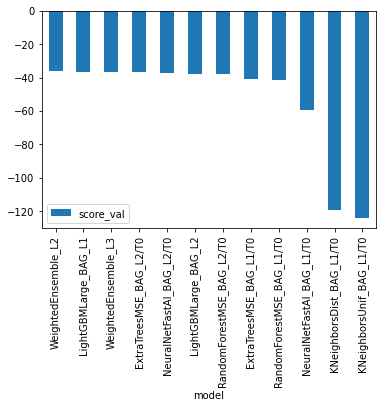

In [71]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar', x='model',y='score_val')

In [72]:
submissions_with_hpo = submission
submissions_with_hpo["count"] = predictions
submissions_with_hpo.loc[predictions < 0,"count"] = 0 

In [79]:
submissions_new_hpo.to_csv("submission_with_hpo.csv", index=False)

#### Submit a prediction submission from a model to Kaggle for scoring.

In [80]:
!kaggle competitions submit -c bike-sharing-demand -f submission_with_hpo.csv -m "Third Submission with New features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 434kB/s]
Successfully submitted to Bike Sharing Demand

In [81]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                      date                 description                                              status    publicScore  privateScore  
----------------------------  -------------------  -------------------------------------------------------  --------  -----------  ------------  
submission_with_hpo.csv       2022-01-28 21:31:00  Third Submission with New features with hyperparameters  complete  0.50718      0.50718       
submission_no_hpo.csv         2022-01-28 21:21:23  Second Submission with New Features                      complete  0.54732      0.54732       
submission.csv                2022-01-28 21:04:40  First submission                                         complete  1.39795      1.39795       
submission.csv                2022-01-28 21:01:58  First submission                                         error     None         None          


Experiment: Trying individual models

In [75]:
def predict_evaluate(Model):
    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['count','datetime']).values, df_train["count"], test_size=0.2, random_state=42)
    
    model = Model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    print(f"r2_score of {model.__repr__()} is {r2_score(y_test, predictions)}")
    print(f"mean_absolute_error of {model.__repr__()} is {mean_absolute_error(y_test, predictions)}")
    print(f"mean_squared_error of {model.__repr__()} is {mean_squared_error(y_test, predictions)}")

In [76]:
predict_evaluate(MLPRegressor(random_state=1, max_iter=500))

r2_score of MLPRegressor(max_iter=500, random_state=1) is 0.5618203146066907
mean_absolute_error of MLPRegressor(max_iter=500, random_state=1) is 87.20586160436999
mean_squared_error of MLPRegressor(max_iter=500, random_state=1) is 14462.968773138853


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [77]:
predict_evaluate(ExtraTreesRegressor(n_estimators=100, random_state=0))

r2_score of ExtraTreesRegressor(random_state=0) is 0.8677064151214615
mean_absolute_error of ExtraTreesRegressor(random_state=0) is 43.72598714416897
mean_squared_error of ExtraTreesRegressor(random_state=0) is 4366.6058714416895


In [78]:
predict_evaluate(AdaBoostRegressor(random_state=0, n_estimators=100))

r2_score of AdaBoostRegressor(n_estimators=100, random_state=0) is 0.5679924053787657
mean_absolute_error of AdaBoostRegressor(n_estimators=100, random_state=0) is 97.96070991517506
mean_squared_error of AdaBoostRegressor(n_estimators=100, random_state=0) is 14259.246968871787


# Report

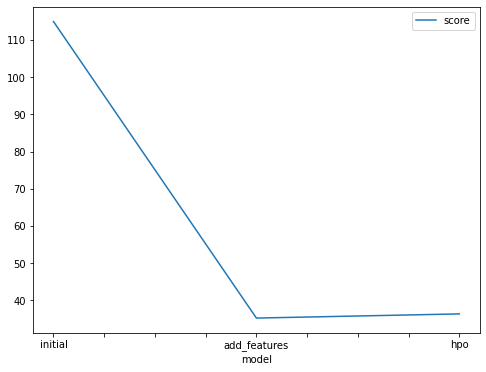

In [82]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [114.951355, 35.202436, 36.321060]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_train_score.png')

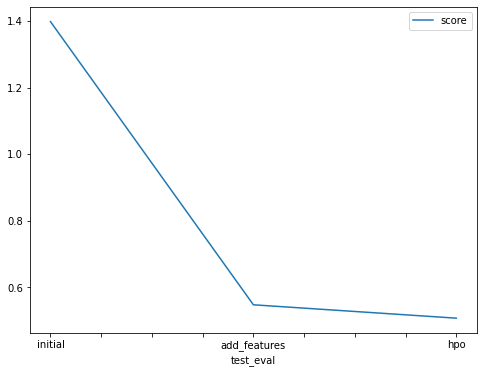

In [83]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.39795, 0.54732, 0.50718]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('img/model_test_score.png')

In [84]:
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [25, 25, 100],
    "hpo2": [5, 5, 15],
    "hpo3": [True, True, True],
    "score": [1.39795, 0.54732, 0.50718]
})

,model,hpo1,hpo2,hpo3,score
0,initial,25,5,True,1.39795
1,add_features,25,5,True,0.54732
2,hpo,100,15,True,0.50718


# Report: Predict Bike Sharing Demand with AutoGluon Solution
#### José Chrystian Lima Pacheco

## Initial Training
### What did you realize when you tried to submit your predictions? What changes were needed to the output of the predictor to submit your results?

The First training did not involve any manipulation of the data, it was just a quick training to understand how Autogluon would perform on the "raw" data, it did not achieve bad results, which showed us that with hyperparameter tuning and feature engineering it would make us achieve even better results .

### What was the top ranked model that performed?
For our first training round, the WeightedEnsemble_L3 model performed the best, with the lowest mse, despite the fit_time of 524.764818, its predict time was 0.000621.
![model_performance.png](img/model_performance.png)
## Exploratory data analysis and feature creation
### What did the exploratory analysis find and how did you add additional features?
First of all we analyzed that there were some features that could be created from the datetime, features like day, time and month.

We can also see that it would be possible to transform the different time and temperature intervals into categorical features.

### How much better did your model preform after adding additional features and why do you think that is?
After adding the new features the result in the submission went from 1.39795 to 0.54732
Models tend to work well with more features and also with categorical features, so when we join or do transformations on numerical features that can vary a lot, it ends up resulting in a better inference

## Hyper parameter tuning
### How much better did your model preform after trying different hyper parameters?
After adding the different hyper parameters the result in the submission went from 0.54732 to 0.50718

### If you were given more time with this dataset, where do you think you would spend more time?
I would spend more time understanding the Dataset and doing feature engineering, and focusing on a set of specific models that performed well, doing hyperparemeter tuning.
[1.39795, 0.54732, 0.50718]
### Create a table with the models you ran, the hyperparameters modified, and the kaggle score.
|model|hpo1|hpo2|hpo3|score|
|--|--|--|--|--|
|initial|25|25|100|1.39795|
|add_features|5|5|15|0.54732|
|hpo|True|True|True|0.50718|

### Create a line plot showing the top model score for the three (or more) training runs during the project.

![model_performance.png](img/model_train_score.png)

### Create a line plot showing the top kaggle score for the three (or more) prediction submissions during the project.


![model_test_score.png](img/model_test_score.png)

## Summary
In this experiment we used Autogluon, which is an autoML library that helps us a lot in performing experiments.

This experiment was divided into 3 stages, the first using only raw data, the second performing feature engineering and the third featuring engineering + selected hyperparameters, in each submission the final score in Kaggle was improving and showing that our efforts are worth it.